In [15]:

import kagglehub
import os
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import random
import math
import torch
from tqdm import tqdm


In [16]:
path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")
path = ".."+path+"/New Plant Diseases Dataset(Augmented)"+"/New Plant Diseases Dataset(Augmented)"
train_path = path+"/train"
val_path = path+"/valid"

Using Colab cache for faster access to the 'new-plant-diseases-dataset' dataset.


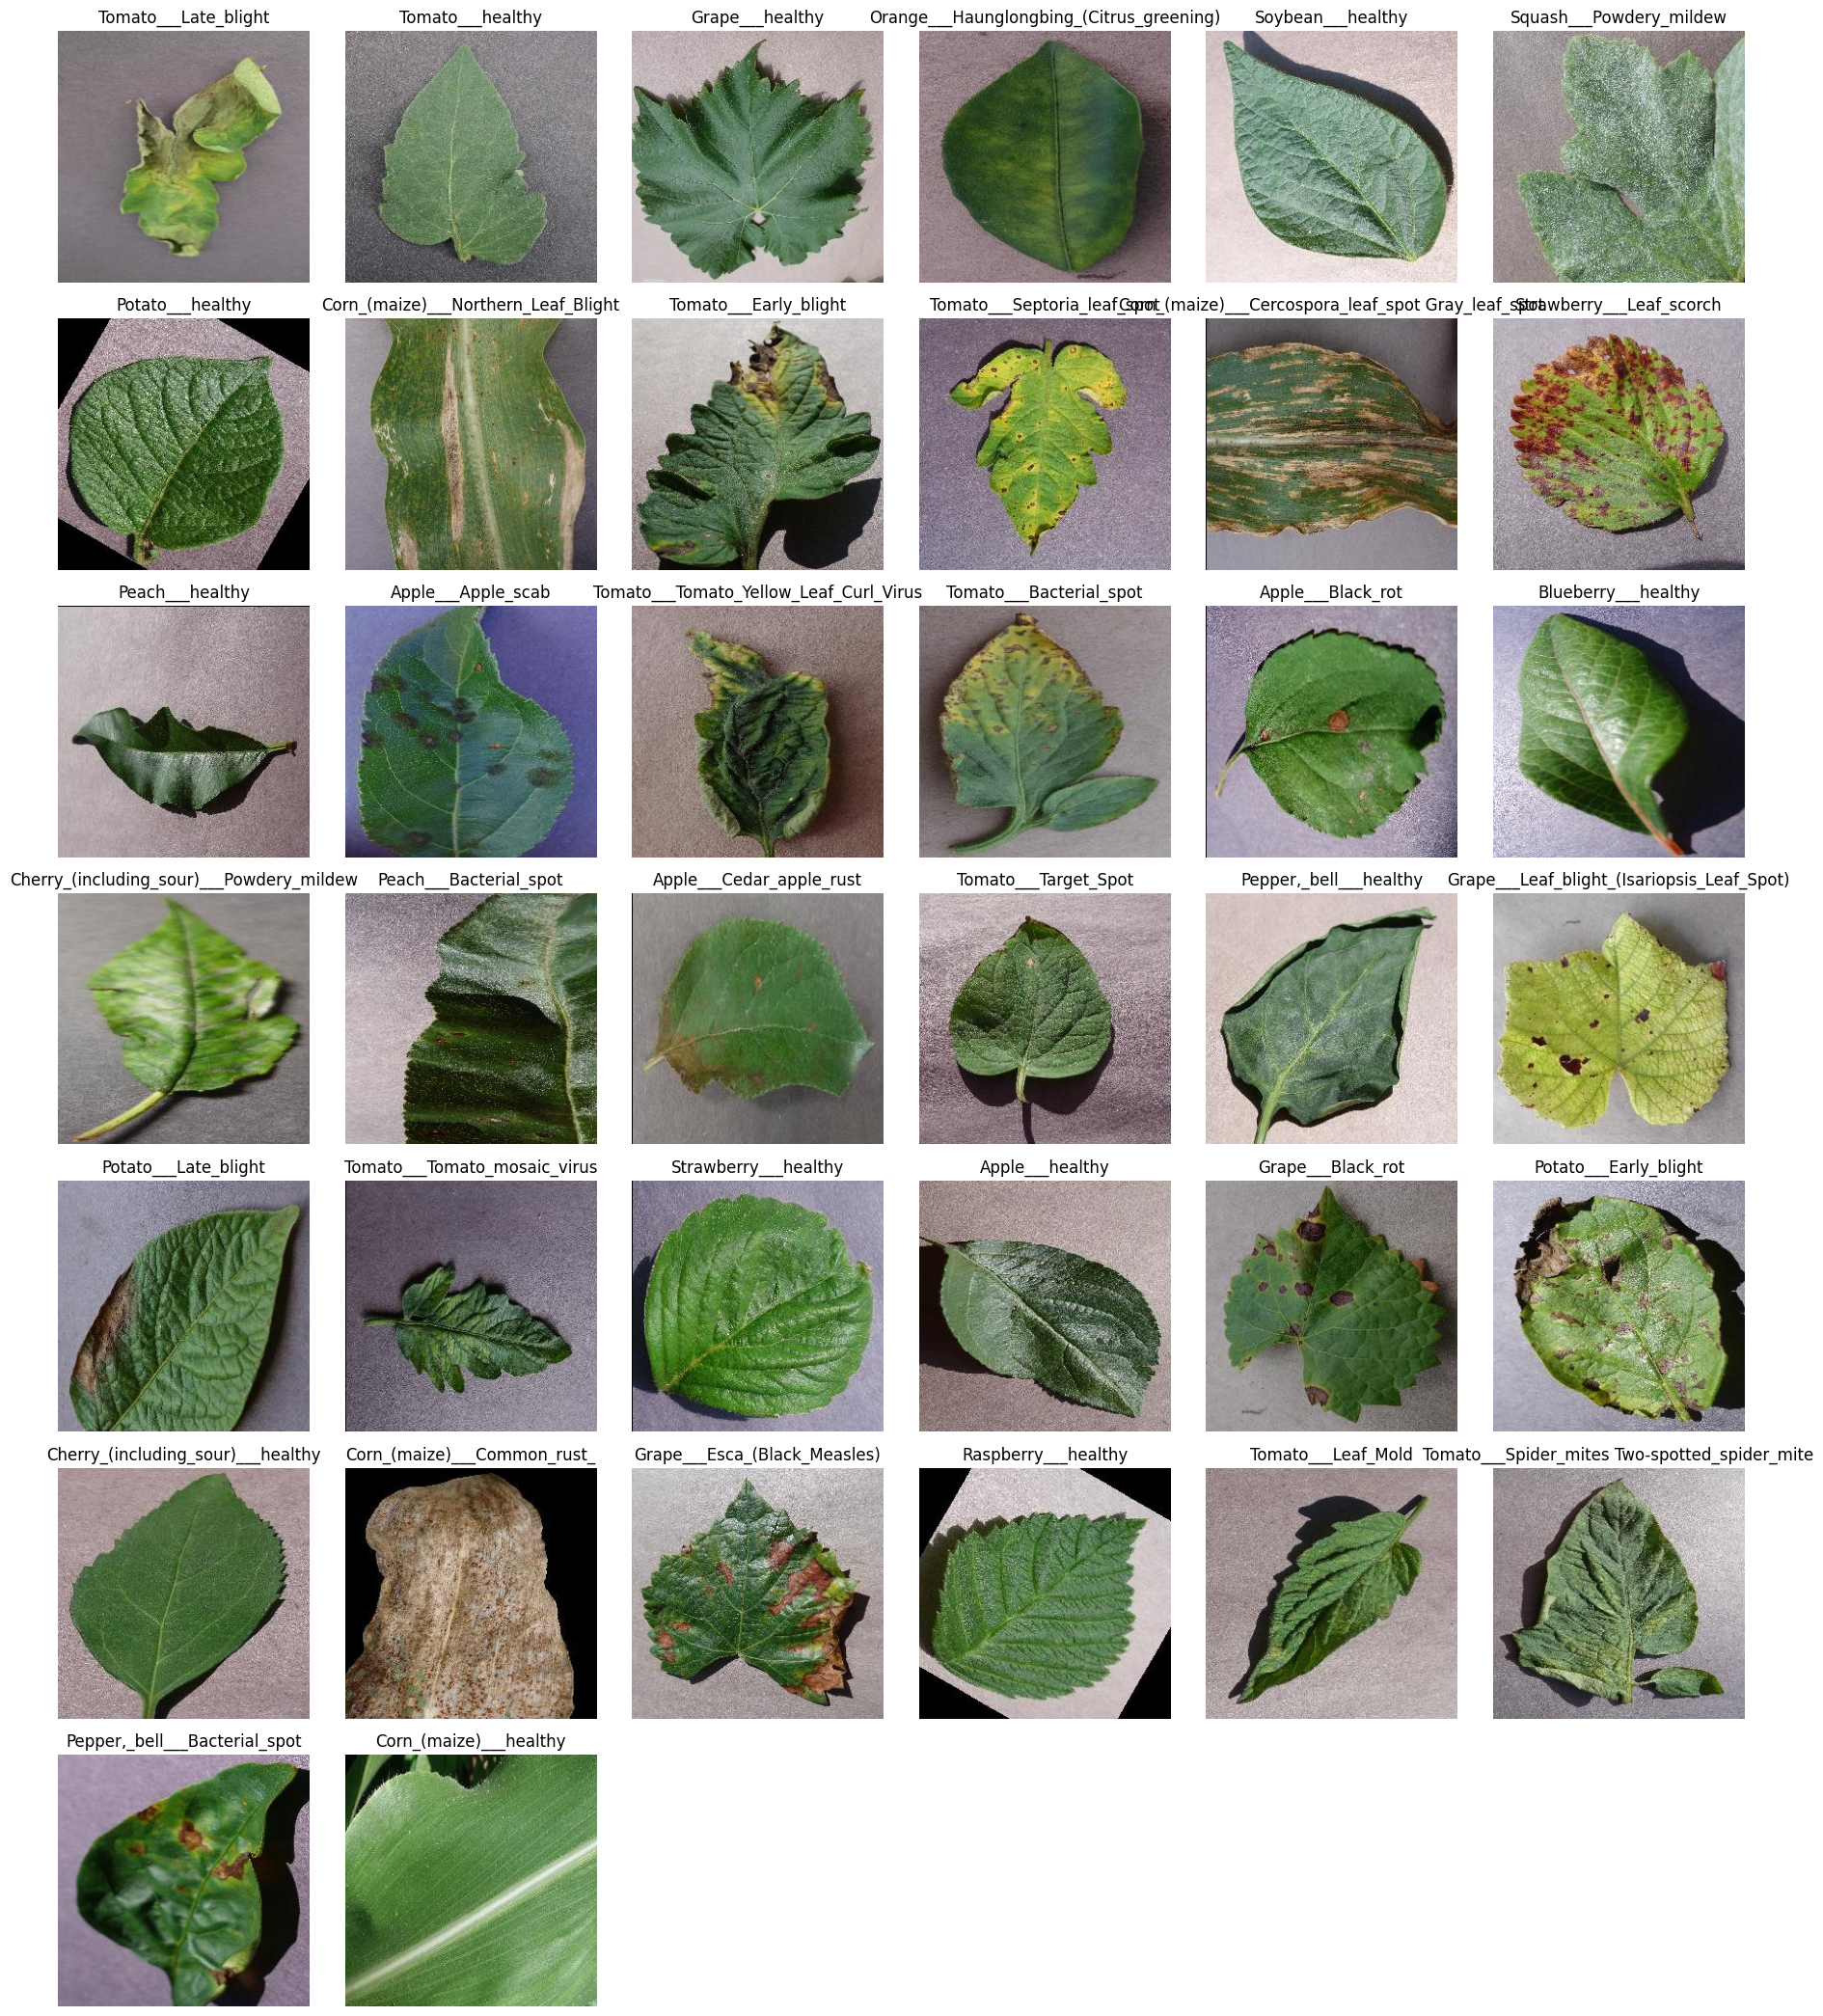

In [18]:
classes = [name for name in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, name))]

images = []
for class_name in classes:
    class_dir = os.path.join(train_path, class_name)
    img_name = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_name)
    img = Image.open(img_path)
    images.append((class_name, img))


num_classes = len(images)
cols = 6
rows = math.ceil(num_classes / cols)

plt.figure(figsize=(3*cols, 3*rows))

for i, (class_name, img) in enumerate(images):
    ax = plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [19]:
def compute_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=2)
    mean = 0.
    std = 0.
    total_images = 0

    for images, _ in tqdm(loader):
        batch_samples = images.size(0)  # batch size (N)
        images = images.view(batch_samples, images.size(1), -1)  # [N, C, H*W]
        mean += images.mean(2).sum(0)
        std  += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images
    return mean, std

tmp_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
tmp_dataset = datasets.ImageFolder(root=train_path, transform=tmp_transform)

mean, std = compute_mean_std(tmp_dataset)
print("Mean:", mean)
print("Std:", std)


100%|██████████| 1099/1099 [05:41<00:00,  3.22it/s]

Mean: tensor([0.4760, 0.5004, 0.4266])
Std: tensor([0.1775, 0.1509, 0.1960])


In [30]:
data_transformer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4760, 0.5004, 0.4266],
                         std=[0.1775, 0.1509, 0.1960]),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=15),       ## only for training
])


In [31]:
train_dataset = datasets.ImageFolder(root=train_path, transform=data_transformer)
val_dataset   = datasets.ImageFolder(root=val_path, transform=data_transformer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False,num_workers=2)

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

print("Train loader size:", len(train_loader))
print("Validation loader size:", len(val_loader))


Train dataset size: 70295
Validation dataset size: 17572
Train loader size: 2197
Validation loader size: 550


In [32]:
new_transformed_img = data_transformer(img)
print(new_transformed_img)

tensor([[[-2.6375, -2.5712, -2.5270,  ..., -1.0468, -1.1352, -1.2898],
         [-2.6375, -2.5712, -2.5270,  ..., -1.1352, -1.2898, -1.2014],
         [-2.6154, -2.5933, -2.5491,  ..., -0.9363, -1.0026, -0.9584],
         ...,
         [-0.9805, -0.8921, -1.0689,  ...,  0.8753,  1.0742,  0.7428],
         [-1.1572, -1.1352, -1.3119,  ...,  1.0963,  1.2067,  0.9637],
         [-1.3561, -1.3119, -1.2235,  ...,  0.9637,  1.1184,  1.1626]],

        [[-3.2122, -3.1602, -3.1342,  ..., -0.2235, -0.3275, -0.5094],
         [-3.2122, -3.1602, -3.1342,  ..., -0.3275, -0.5094, -0.4055],
         [-3.1862, -3.1862, -3.1602,  ..., -0.0936, -0.1716, -0.1196],
         ...,
         [-0.5614, -0.4574, -0.6653,  ...,  1.6996,  1.9334,  1.5436],
         [-0.7433, -0.6913, -0.8992,  ...,  1.9594,  2.0894,  1.8035],
         [-0.9512, -0.8992, -0.7953,  ...,  1.8035,  1.9854,  2.0374]],

        [[-2.1765, -2.1365, -2.0765,  ..., -0.9360, -1.0161, -1.1561],
         [-2.1765, -2.1365, -2.0765,  ..., -1